# Lab 4 Power Iteration and Link Preidction
## Due: Midnight, October 2nd
In this lab, we will introduce
1. **Power iteration for Eigenvector Centrality**
2. **Eigendecompstion for Eigenvector Centrality**
3. **Node Similarity**
4. **Link Preidciton**


## Save Your Notebook! 
- Click on File (upper left corner), Select “Save” or press Ctrl+S.
- Important: You may loose your modification to a notebook if you do not Save it explicitly.
- Advice: Save often.  


## Submission
- Please follow the instructions and finish the exercises.
- After you finish the lab, please Click on File, Select “Download .ipynb”
- After download is complete, Click on File, Select “Print”, and and Choose ``Save as PDF''
- Submit both the Notebook file and the PDF File as your submission for Lab 4.

# 1. Preparation
Before we start to visualize the networks, we have to install the packages and prepare the network dataset. 
# 1.1 Connect this Colab notebook with your Google Drive


In [1]:
# The following code will mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1.2. Install Packages
The following packages should be avaialbe in Colab. In case not, run the following codes

In [2]:
!pip install matplotlib
!pip install networkx
!pip install numpy

# 1.2. Import and Visualize the Graph
We will use the same undirected weighted graph as we used in Lab 3. If you didn't upload to Google drive, please download it from Canvas and upload it to the folder DS402 of Google Drive. Next, we will load the graph and visualize it. In particular, the width of the edge is based on the weight of edge.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

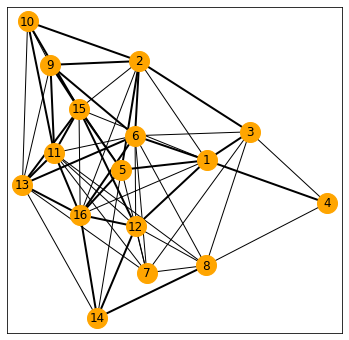

In [4]:
%matplotlib inline
plt.figure(figsize=(6,6))
G = nx.read_edgelist(path="/content/gdrive/My Drive/DS402/undirected_weighted.edgelist", delimiter=' ', nodetype=int, data=(('weight',float),))
pos = nx.fruchterman_reingold_layout(G)
edges = []
weights = []
for (source, target, weight) in G.edges.data('weight'):
    edges.append((source, target))
    weights.append(weight)
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='orange')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights*32)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.show()

You should see the visualization of the graph. The thicker the edge, the larger the weight. The weight plays an important role in eigenvector centrality.

# 2. Power Iteration for Eigenvector Centrality
We will implement power iteration for eigenvector centrality. In eigenvector centrality, a node aggregate its neighbors' centralities as </br>
\begin{equation}
C_e(v_i) = \frac{1}{\lambda}\sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_e(v_j)
\end{equation}
where $\mathcal{N}^{in}(v_i)$ denotes the set of nodes that have incoming links to node $v_i$. It is a recursive definition as the calcualtion of $C_e(v_i)$ depends on $C_e(v_j)$, and the calcualtion of  $C_e(v_j)$ depends on $C_e(v_i)$. We will use power iteration to learn the eigenvector centralities. The basic idea of power iteration is Every node starts with the same score, and then each node gives away its score to its successors. We iteratively update the score until convergence.

**Power Iteration**</br>
1. Initialization: set $C_e(v_1), C_e(v_2), \dots, C_e(v_N)$ to 1
2. Update $C_e(v_1), C_e(v_2), \dots, C_e(v_n)$ based on the equation
\begin{equation}
C_e(v_i) \leftarrow \sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_e(v_j)
\end{equation}
3. Normalize each term as 
\begin{equation}
C_e(v_i) \leftarrow \frac{C_e(v_i)}{\sqrt{\sum_{j=1}^N C_e(v_j)^2}}
\end{equation}
4. Repeat 2 and 3 until convergence

## 2.1 Basic Operations
Before we implement the power iteration. Let's first introduce some basic operations

In [5]:
# Get nodes of a Graph: G.nodes
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16))

In [6]:
# Get neighbor of node 1： G.neighbors(1)
current_node = 1
list(G.neighbors(current_node))

[2, 3, 4, 5, 6, 12, 15, 16]

In [7]:
# Get weights of edges connecting to node 1
for neighbor in G.neighbors(current_node):
    print(G.get_edge_data(neighbor, current_node)['weight'])

1.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0


In [8]:
# With the above operations, we can update the eigenvector centrality of a node as follows
Ce = {node:1.0 for node in G.nodes} # create a dictionary with key as the nodes and values are 1
new_score = 0
for neighbor in G.neighbors(current_node):
    new_score += Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] # aggregate the neighbors' centralities
print(new_score)

13.0


In [9]:
# If you are familar with Python, the above code can also be written as
Ce = {node:1.0 for node in G.nodes} # create a dictionary with key as the nodes and values are 1
new_score = sum(Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] for neighbor in G.neighbors(current_node))
print(new_score)

13.0


## 2.2 Implementing Power Iteration
With the basic operations above, we can implement power iterations. Note we use **maxiter** to control the iterations as we want to show how the eigenvector centralarity changes.

In [10]:
# create a dictionary with key as the nodes and values are 1
Ce = {node:1.0 for node in G.nodes}
maxiter = 10
Ce_record = np.ones((len(G), maxiter+1)) # we use this to record how Ce changes
Ce_tmp = {node:0.0 for node in G.nodes}  # this is used to store the intermediate value of Ce

In [11]:
# main loop
for i in range(0, maxiter):
    
    # for each node, calculate their new eigenvector score and put in Ce_tmp
    for current_node in Ce.keys():
        # aggregate the centrality score from connected neighbors
        Ce_tmp[current_node] = sum(Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] for neighbor in G.neighbors(current_node))

    # normalization
    normalization_term = sum(Ce_tmp[node]**2 for node in Ce_tmp) ** 0.5
    for node in Ce:
        Ce[node] = Ce_tmp[node] / normalization_term

    # record the values
    for node,j in zip(Ce, range(0, len(G))):
        Ce_record[j,i+1] = Ce[node]


eigenvector centralities: {1: 0.25593270431263265, 2: 0.27865894783117623, 3: 0.14527372377314798, 4: 0.06614117366997928, 5: 0.2524170750562014, 6: 0.3237006056714063, 7: 0.1436295731898402, 8: 0.133130799692465, 9: 0.27217739004050273, 10: 0.20269006104743637, 11: 0.31362082773535854, 12: 0.2615701195104702, 13: 0.2865662529212915, 14: 0.16840958953144727, 15: 0.33932052632363563, 16: 0.3419906953693549}


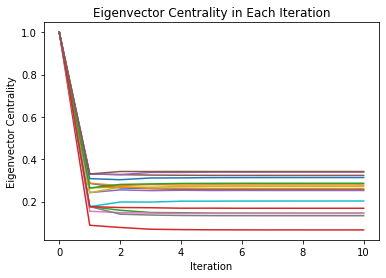

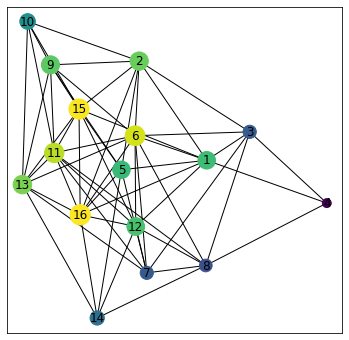

In [12]:
# results
print('eigenvector centralities: {}'.format(Ce))

# visualize how the centrality changes
plt.figure()
plt.plot(np.transpose(Ce_record))
plt.title('Eigenvector Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality')
plt.show()

# visualiz the graph with node size reflecting the centrality
plt.figure(figsize=(6,6))
nodesize = [Ce[node]*1200 for node in Ce]
nx.draw_networkx(G, pos, with_labels=True, node_size=nodesize, font_size=12, node_color=nodesize)
plt.show()

From the above visualization, we can observe that after 3 iterations, the algorithm converges.

## Exercise 1: Power Iteration for Katz Centraltiy
Following the above example, please implement power iteration for Katz Centrality. The equation for Katz centrality is 
\begin{equation}
C_k(v_i) = \alpha\sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_k(v_j) + \beta
\end{equation}
Please set $\alpha=0.85$, $\beta=0.15$

Power Iteration</br>
1. Initialization: set $C_k(v_1), C_k(v_2), \dots, C_k(v_N)$ to 1
2. Update $C_k(v_1), C_k(v_2), \dots, C_k(v_n)$ based on the equation
\begin{equation}
C_k(v_i) \leftarrow \sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_k(v_j) + \frac{\beta}{\alpha}
\end{equation}
3. Normalize each term as 
\begin{equation}
C_k(v_i) \leftarrow \frac{C_k(v_i)}{\sqrt{\sum_{j=1}^N C_k(v_j)^2}}
\end{equation}
4. Repeat 2 and 3 until convergence

In [67]:
Ck = {node:1.0 for node in G.nodes}
maxiter = 10
alpha=0.85
beta=0.15
Ck_record = np.ones((len(G), maxiter+1)) 
Ck_tmp = {node:0.0 for node in G.nodes} 

In [68]:
for i in range(0, maxiter):

    for current_node in Ck.keys():
  
        Ck_tmp[current_node] = sum((beta/alpha) + Ck[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] for neighbor in G.neighbors(current_node))

    normalization_term = sum(Ck_tmp[node]**2 for node in Ck_tmp) ** 0.5
    for node in Ck:
        Ck[node] = Ck_tmp[node] / normalization_term

    for node,j in zip(Ck, range(0, len(G))):
        Ck_record[j,i+1] = Ck[node]

katz centralities: {1: 0.2641281281764855, 2: 0.2749887492711374, 3: 0.16878647397680366, 4: 0.08142772977887983, 5: 0.24648738695530087, 6: 0.3305288215656039, 7: 0.17529687729765395, 8: 0.16970830658083558, 9: 0.25812794928367006, 10: 0.18866463637735714, 11: 0.30857551169258646, 12: 0.26682581214467954, 13: 0.2794457908891323, 14: 0.17154598830900658, 15: 0.32389921696526913, 16: 0.32999243902594305}


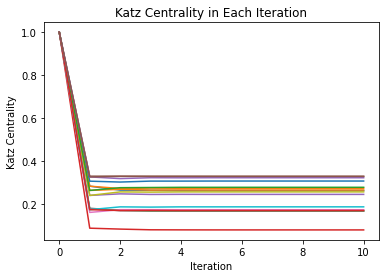

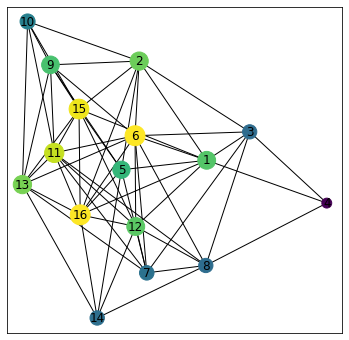

In [69]:
print('katz centralities: {}'.format(Ck))

plt.figure()
plt.plot(np.transpose(Ck_record))
plt.title('Katz Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Katz Centrality')
plt.show()

plt.figure(figsize=(6,6))
nodesize = [Ck[node]*1200 for node in Ck]
nx.draw_networkx(G, pos, with_labels=True, node_size=nodesize, font_size=12, node_color=nodesize)
plt.show()

## 2.2 Vectorization
The equation for eigenvector centrality can be vectrozied as
\begin{equation}
\mathbf{c} = \frac{1}{\lambda}\mathbf{A}^T \mathbf{c}
\end{equation}
Where $\mathbf{c}$ is a vector of size $N$ with the $i$-th element as the eigenvector centrality of the $i$-th node in the graph. With the vectorized version, the implementation is much easier.

**Power Iteration**</br>
1. Initialization: set **c** to all one vector
2. Update **c** based on the equation
\begin{equation}
\mathbf{c} \leftarrow \mathbf{A}^T \mathbf{c}
\end{equation}
3. Normalize each term as 
\begin{equation}
\mathbf{c} \leftarrow \frac{\mathbf{c}}{\|\mathbf{c}\|_2}
\end{equation}
4. Repeat 2 and 3 until convergence

### basic operations
We will first introduce some basice operations

[[0. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1.]
 [1. 0. 2. 0. 2. 2. 0. 0. 2. 2. 0. 0. 0. 0. 1. 1.]
 [2. 2. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 2. 2.]
 [2. 2. 1. 0. 0. 0. 1. 1. 2. 0. 1. 1. 2. 0. 0. 2.]
 [0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 2. 0. 0.]
 [0. 2. 0. 0. 1. 2. 0. 0. 0. 1. 2. 0. 1. 0. 2. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 0. 1. 2. 0. 2. 2.]
 [2. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 2. 2. 2.]
 [0. 0. 0. 0. 0. 2. 1. 0. 1. 1. 2. 0. 0. 1. 2. 2.]
 [0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 2. 1. 0. 0. 2.]
 [1. 1. 0. 0. 2. 0. 0. 0. 2. 2. 2. 2. 2. 0. 0. 1.]
 [1. 1. 0. 0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 2. 1. 0.]]


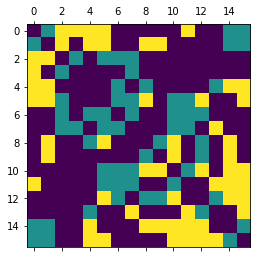

In [70]:
# we can use nx.adjacency_matrix(G) to get the adjacency matrix of G
A = nx.adjacency_matrix(G).todense()
print(A)
plt.matshow(A)

The visualization of the adjency matrix has 3 colors, which represent there weights, yellow: 2, green: 1 and blue: 0

In [71]:
# create a vector of size (A.shape[0], 1)
c = np.ones((A.shape[0], 1))
print(c)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [72]:
# update the the centrality score with the equation
c = np.dot(np.transpose(A), c)
print(c)

[[13.]
 [13.]
 [ 8.]
 [ 4.]
 [11.]
 [15.]
 [ 7.]
 [ 8.]
 [11.]
 [ 8.]
 [14.]
 [12.]
 [12.]
 [ 8.]
 [15.]
 [15.]]


In [73]:
# normalization
c = c / np.linalg.norm(c)
print(c)

[[0.28642422]
 [0.28642422]
 [0.17626106]
 [0.08813053]
 [0.24235896]
 [0.33048949]
 [0.15422843]
 [0.17626106]
 [0.24235896]
 [0.17626106]
 [0.30845685]
 [0.26439159]
 [0.26439159]
 [0.17626106]
 [0.33048949]
 [0.33048949]]


### With these operations, we can now implemnt the power iteration for eigenvector centrality

In [74]:
# initialization
c = np.ones((A.shape[0], 1))

# main loop
maxiter = 10
record_c = np.ones((A.shape[0], maxiter+1))
record_c[:, i] = np.squeeze(c, axis=1)
for i in range(1, maxiter+1):
    c = np.dot(np.transpose(A), c) # c = A^T c
    c = c / np.linalg.norm(c)
    record_c[:,i] = np.squeeze(c, axis=1)

eigenvector centralities: [[0.2559327 ]
 [0.27865895]
 [0.14527372]
 [0.06614117]
 [0.25241708]
 [0.32370061]
 [0.14362957]
 [0.1331308 ]
 [0.27217739]
 [0.20269006]
 [0.31362083]
 [0.26157012]
 [0.28656625]
 [0.16840959]
 [0.33932053]
 [0.3419907 ]]


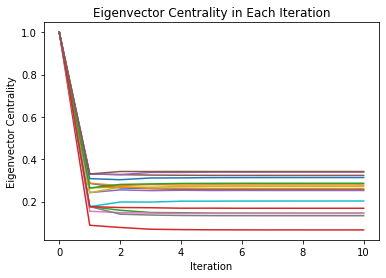

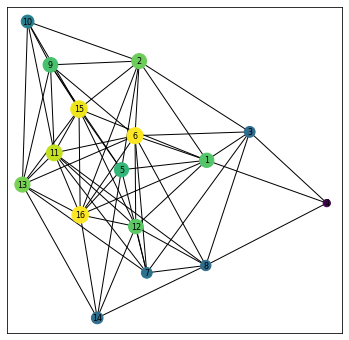

In [75]:
# results
print('eigenvector centralities: {}'.format(c))

# visualize how the centrality changes
plt.figure()
plt.plot(np.transpose(record_c))
plt.title('Eigenvector Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality')
plt.show()

# visualiz the graph with node size reflecting the centrality
plt.figure(figsize=(6,6))
nx.draw_networkx(G, pos, with_labels=True, node_size=list(c*800), font_size=8, node_color=nodesize)
plt.show()

## Exercise 2: Vectorized Version for Katz Centrality
Following the above example, please implement the vectorized version for Katz Centrality. The vectorized equation for Katz centrality is
\begin{equation}
\mathbf{c} = \alpha \mathbf{A}^T \mathbf{c} + \beta \mathbf{1}
\end{equation}
where $\mathbf{c}$ is a vector of size $N$ with the $i$-th element as the Katz centrality of the $i$-th node in the graph. $\mathbf{1}$ is an all one vector. We have provided the code to get the all one vector below.

In [76]:
all_one_vector = np.ones((A.shape[0], 1))
c = np.ones((A.shape[0], 1))

alpha=0.85
beta=0.15
maxiter = 10
record_c = np.ones((A.shape[0], maxiter+1))
record_c[:, i] = np.squeeze(c, axis=1)
for i in range(1, maxiter+1):
    c = alpha * np.dot(np.transpose(A), c) + beta * all_one_vector
    c = c / np.linalg.norm(c)
    record_c[:,i] = np.squeeze(c, axis=1)



katz centralities: [[0.25865655]
 [0.2781912 ]
 [0.15403961]
 [0.07851669]
 [0.25266882]
 [0.32115198]
 [0.15084778]
 [0.14280531]
 [0.26979433]
 [0.20407178]
 [0.31003696]
 [0.26233893]
 [0.2837925 ]
 [0.17419103]
 [0.33414406]
 [0.33730252]]


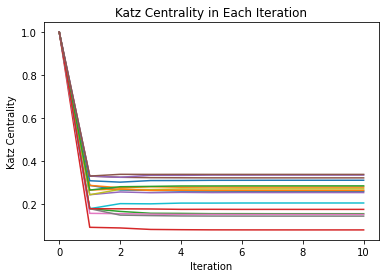

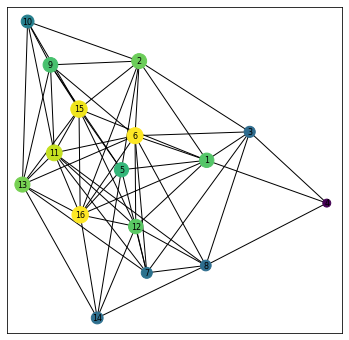

In [77]:
# results
print('katz centralities: {}'.format(c))

# visualize how the centrality changes
plt.figure()
plt.plot(np.transpose(record_c))
plt.title('Katz Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Katz Centrality')
plt.show()

# visualiz the graph with node size reflecting the centrality
plt.figure(figsize=(6,6))
nx.draw_networkx(G, pos, with_labels=True, node_size=list(c*800), font_size=8, node_color=nodesize)
plt.show()

## 2.4 Eigendecomposition for eigenvector centrality
Eigenvector centrality is called "eigenvector" becasue the scores are actually the eigenvector of the largest eigenvalues of the adjacency matrix. Next we will show how to use eigendecomposition to get the centrality score

In [78]:
# eigen decomposition of A
eigenValues, eigenVectors = np.linalg.eigh(A)

# sort the eigenvalues from largest to smallest
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
print(eigenValues)

[11.94903763  4.71745713  4.00945036  2.34246659  1.29210882  0.84385161
  0.26388917 -0.3047154  -0.56103915 -1.69079368 -2.00184459 -2.53573353
 -3.11296371 -4.60215813 -5.07836522 -5.53064788]


In [79]:
# The eigenvector centrality is obtained as the eigenvector corresponding to the largest eigenvalue
c_eig = np.transpose(np.squeeze(eigenVectors[:,0], axis=1))
print(c_eig)

[[0.25593012]
 [0.27866195]
 [0.14526482]
 [0.06613518]
 [0.25240925]
 [0.32369758]
 [0.14363115]
 [0.13312674]
 [0.27218106]
 [0.20269293]
 [0.31362702]
 [0.26156113]
 [0.28656748]
 [0.16840979]
 [0.33932951]
 [0.34199123]]


## Exercise 3: Verify that c_eig and c we get in 2.2 are the same
To verify this, please calculate the l2 distance of c_eig and c, i.e.
\begin{equation}
    \|c\_eig - c\|_2 = \sqrt{\sum_{i} (c(i) - c\_eig(i))^2}
\end{equation}
Hint: You can do this by calling np.linalg.norm(c - c_eig)

In [82]:
distance = np.linalg.norm(c - c_eig)
print(distance)

0.022390688253558163


Question: Are c_eig and c the same? Why?

Answer: They are almost the same because the distance is very small, and it exists some errors. 

# 3. Link Prediction
In this part, we will implement the Jaccard Similairy and Cossine for Link Prediction

## 3.1 Basic Operations

In [83]:
# get neighbors of node u and v
u = 1 # assume u is node 1
v = 2 # assume v is node 2
u_neighbors = set(G.neighbors(u))
v_neighbors = set(G.neighbors(v))
print(u_neighbors)
print(v_neighbors)

{2, 3, 4, 5, 6, 12, 15, 16}
{1, 3, 5, 6, 9, 10, 15, 16}


In [84]:
# union of two sets
unique_friends = u_neighbors.union(v_neighbors)
print(unique_friends)

# intersect of 
common_friends = u_neighbors.intersection(v_neighbors)
print(common_friends)

{1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 16}
{3, 5, 6, 15, 16}


In [85]:
# number of common_friends
len(common_friends)
print(len(common_friends))

# number of unique_friends
len(unique_friends)
print(len(unique_friends))

5
11


## Exercise 4: Jaccard Similarity of Two nodes
The jaccard simialrity of two nodes u and v is defined as
\begin{equation}
jaccard\_simialrity(u,v) = \frac{\Big| u\_neighbors \cap v\_neighbors \Big|}{\Big| u\_neighbors \cup v\_neighbors \Big|}=\frac{\# of common friends of u and v}{\# of unique friends of u and v}
\end{equation}
With the definiton and above code please finish the following code

In [86]:
# TODO: Please calculate the jaccard similarity of node u and v, and return the score
def jaccard_similarity(G, u, v):
    """
    This function calculate the jaccard similarity of two nodes u and v based on the graph structure G
    :param G: the networkx graph
    :param u: node
    :param v: node
    :return: a scalar, the jaccard simialrity of node u and v
    """
    if u not in G.nodes or v not in G.nodes:
        raise ValueError
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    
    ## plese calculate the jaccard simialrity ??????????????????????
    unique_friends = u_neighbors.union(v_neighbors)
    common_friends = u_neighbors.intersection(v_neighbors)
    jaccard_similarity = len(common_friends)/len(unique_friends)
    # return the similarity
    return  jaccard_similarity

    

In [87]:
# call your function to calculate the jaccard similarity of node 1 and 2
# if you see 0.45454545454545453, then you answer is correct
similarity = jaccard_similarity(G, 1, 2)
print(similarity)
if similarity == 0.45454545454545453:
    print('Correct!')
else:
    print('Incorrect')

0.45454545454545453
Correct!


## Exercise 5: Cosine Similarity
The cosine simialrity of two nodes u and v is defined as
\begin{equation}
jaccard\_simialrity(u,v) = \frac{\Big|u\_neighbors \cap v\_neighbors \Big|}{\sqrt{|u\_neighbors| \times |v\_neighbors|}}=\frac{\# of common friends of u and v}{\sqrt{u\_neighbors| \times |v\_neighbors|}}
\end{equation}
With the definiton and above code please finish the following code

In [88]:
# TODO: Please calculate the cosine similarity of node u and v, and return the score
def cosine_similarity(G, u, v):
    """
    This function calculate the cosine similarity of two nodes u and v based on the graph structure G
    :param G: the networkx graph
    :param u: node
    :param v: node
    :return: a scalar, the cosine simialrity of node u and v
    """
    if u not in G.nodes or v not in G.nodes:
        raise ValueError
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    ## plese calculate the cosine simialrity ??????????????????????
    common_friends = u_neighbors.intersection(v_neighbors)
    cosine_similarity = len(common_friends)/(len(u_neighbors) * len(v_neighbors)) **0.5
    # return the cosine similarity
    return cosine_similarity
    

In [89]:
# call your function to calculate the cosine similarity of node 1 and 2
similarity = cosine_similarity(G, 1, 2)
print(similarity)
if similarity == 0.625:
    print('Correct!')
else:
    print('Incorrect')

0.625
Correct!


## Exercise 6: Link Prediction Example
Use jaccard simialrity to recommend top 2 users to node 1

In [146]:
# TODO: 
user = 1 # the user we want to suggest friends
# the set of nodes that are not linked with the user
preds = []
for node in G.nodes:
    if node not in G.neighbors(user) and node != user:
        # call your function to calculate the jaccard similarity of user and node
        node1_neighbors = set(G.neighbors(user))
        node2_neighbors = set(G.neighbors(node))
        unique_node = node1_neighbors.union(node2_neighbors)
        common_node = node1_neighbors.intersection(node2_neighbors)
        similarity = len(common_node)/len(unique_node)

        # store the simialrity to preds
        preds.append((user, node, similarity))
        

# rank based on the jaccard similarity
ranked = sorted(preds, key=lambda x: x[2], reverse=True)
print(ranked)

[(1, 7, 0.36363636363636365), (1, 8, 0.36363636363636365), (1, 9, 0.36363636363636365), (1, 11, 0.3076923076923077), (1, 14, 0.3), (1, 13, 0.23076923076923078), (1, 10, 0.18181818181818182)]


Question: Which two nodes should we recommende to node 1? Why?

Answer: 7 and 8, their similarities are ranked as top 2.